## Capstone Project Notebook 03/02/2026 Function 8 ##
### Goal: MAXIMIZE the objective function

In [1]:
# Section 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
wk = 2 # Set week number here

## Load Updated Dataset 
F8 is **8D** - requires 100 MILLION points for basic grid coverage!

In [3]:
# Load the updated dataset
INPUT_FILE = 'f8_W2_inputs.npy'   # Shape (41, 8)
OUTPUT_FILE = 'f8_W2_outputs.npy' # Shape (41,)

In [4]:
X = np.load(INPUT_FILE)  # 8D inputs
Y = np.load(OUTPUT_FILE) # Outputs

In [5]:
# Display data summary
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"\n8D Problem - LITERALLY IMPOSSIBLE WITHOUT BAYESIAN OPTIMIZATION!")
print(f"Search space = 100,000,000 grid points (10^8)")
print(f"Your coverage = {100*X.shape[0]/1e8:.6f}%")
print(f"\nThis is THE ultimate test of Bayesian Optimization!")

Input data shape: (41, 8)
Output data shape: (41,)

8D Problem - LITERALLY IMPOSSIBLE WITHOUT BAYESIAN OPTIMIZATION!
Search space = 100,000,000 grid points (10^8)
Your coverage = 0.000041%

This is THE ultimate test of Bayesian Optimization!


In [6]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D (8D problem!)")
print(f"Current best (MAXIMUM): {Y.max():.3f}")
X = np.atleast_2d(X)
Y = Y.ravel()

Loaded 41 points in 8D (8D problem!)
Current best (MAXIMUM): 9.598


## Data Analysis

In [7]:
print("="*70)
print("F8 DATASET ANALYSIS (8D)")
print("="*70)
print(f"\nInput ranges:")
for i in range(8):
    print(f"  X{i+1}: [{X[:, i].min():.4f}, {X[:, i].max():.4f}]")

print(f"\nOutput statistics:")
print(f"  Best (maximum):  {Y.max():.3f}")
print(f"  Worst:           {Y.min():.3f}")
print(f"  Mean:            {Y.mean():.3f}")
print(f"  Median:          {np.median(Y):.3f}")
print(f"  Std:             {Y.std():.3f}")

# Find best point
best_idx = np.argmax(Y)
print(f"\n🎯 BEST POINT SO FAR:")
for i in range(0, 8, 4):
    print(f"  X{i+1}={X[best_idx, i]:.4f}, X{i+2}={X[best_idx, i+1]:.4f}, X{i+3}={X[best_idx, i+2]:.4f}, X{i+4}={X[best_idx, i+3]:.4f}")
print(f"  Output: {Y[best_idx]:.3f}")

# Show top 10 points
sorted_indices = np.argsort(Y)[::-1]
print(f"\n📊 TOP 10 POINTS:")
for i in range(min(10, len(Y))):
    idx = sorted_indices[i]
    marker = "⭐" if idx == best_idx else "  "
    x_str = ', '.join([f'{x:.3f}' for x in X[idx]])
    print(f"{marker} {i+1:2d}. X=[{x_str}] → Y={Y[idx]:6.2f}")

F8 DATASET ANALYSIS (8D)

Input ranges:
  X1: [0.0091, 0.9859]
  X2: [0.0034, 0.9740]
  X3: [0.0229, 0.9989]
  X4: [0.0090, 0.9030]
  X5: [0.0096, 0.9869]
  X6: [0.0221, 0.9902]
  X7: [0.0359, 0.9929]
  X8: [0.0420, 0.9888]

Output statistics:
  Best (maximum):  9.598
  Worst:           5.592
  Mean:            7.844
  Median:          7.924
  Std:             0.953

🎯 BEST POINT SO FAR:
  X1=0.0564, X2=0.0660, X3=0.0229, X4=0.0388
  X5=0.4039, X6=0.8011, X7=0.4883, X8=0.8931
  Output: 9.598

📊 TOP 10 POINTS:
⭐  1. X=[0.056, 0.066, 0.023, 0.039, 0.404, 0.801, 0.488, 0.893] → Y=  9.60
    2. X=[0.193, 0.631, 0.417, 0.491, 0.796, 0.655, 0.276, 0.296] → Y=  9.34
    3. X=[0.481, 0.102, 0.219, 0.677, 0.248, 0.244, 0.164, 0.716] → Y=  9.18
    4. X=[0.145, 0.119, 0.421, 0.388, 0.155, 0.875, 0.511, 0.729] → Y=  9.14
    5. X=[0.044, 0.014, 0.258, 0.578, 0.051, 0.159, 0.591, 0.078] → Y=  9.01
    6. X=[0.009, 0.472, 0.516, 0.430, 0.469, 0.460, 0.579, 0.507] → Y=  9.01
    7. X=[0.144, 0.937, 

## Section 2: Fit Gaussian Process Surrogate Model

In [8]:
# Kernel for 8D problem - larger noise bound
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-2, 1e4)) * \
         Matern(length_scale=0.5, length_scale_bounds=(0.01, 10.0), nu=2.5) + \
         WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 10))

In [9]:
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=30,
    normalize_y=True,
    random_state=42
)

In [10]:
# Fit the GP model
gp.fit(X, Y)
print(f"GP fitted. Learned kernel: {gp.kernel_}")

GP fitted. Learned kernel: 4.35**2 * Matern(length_scale=3.59, nu=2.5) + WhiteKernel(noise_level=1.12e-09)


## Section 3: Define Acquisition Functions
**Configured for MAXIMIZATION with higher exploration for 8D**

In [11]:
def expected_improvement(X_new, gp, y_best, xi=0.1):  # Higher xi for 8D
    """EI for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    imp = mu - y_best - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    return ei

def upper_confidence_bound(X_new, gp, kappa=2.5):  # Higher kappa for 8D
    """UCB for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    return mu + kappa * sigma

## Section 4: Optimize Acquisition Functions
Using MAXIMUM restarts for 8D!

In [12]:
# Define search bounds (8D)
bounds = [(0.0, 1.0)] * 8

# Current best value
y_best = Y.max()

print("="*70)
print("OPTIMIZING EXPECTED IMPROVEMENT (EI)")
print("="*70)

def neg_ei(x):
    return -expected_improvement(x.reshape(1, -1), gp, y_best, xi=0.1)[0]

best_ei = np.inf
x_next_ei = None

# MAXIMUM restarts for 8D!
for i in range(200):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ei, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ei:
        best_ei = result.fun
        x_next_ei = result.x

mu_ei, sigma_ei = gp.predict(x_next_ei.reshape(1, -1), return_std=True)

print(f"EI suggests:")
for i in range(0, 8, 4):
    print(f"  X{i+1}={x_next_ei[i]:.6f}, X{i+2}={x_next_ei[i+1]:.6f}, X{i+3}={x_next_ei[i+2]:.6f}, X{i+4}={x_next_ei[i+3]:.6f}")
print(f"Predicted value: {mu_ei[0]:.3f} ± {sigma_ei[0]:.3f}")
print(f"Expected Improvement: {-best_ei:.6f}")

OPTIMIZING EXPECTED IMPROVEMENT (EI)
EI suggests:
  X1=0.000000, X2=0.179296, X3=0.000000, X4=0.071410
  X5=0.929265, X6=0.459979, X7=0.000000, X8=0.541213
Predicted value: 10.220 ± 0.440
Expected Improvement: 0.546828


In [13]:
print("\n" + "="*70)
print("OPTIMIZING UPPER CONFIDENCE BOUND (UCB)")
print("="*70)

kappa = 2.5

def neg_ucb(x):
    return -upper_confidence_bound(x.reshape(1, -1), gp, kappa)[0]

best_ucb = np.inf
x_next_ucb = None

for i in range(200):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ucb, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ucb:
        best_ucb = result.fun
        x_next_ucb = result.x

mu_ucb, sigma_ucb = gp.predict(x_next_ucb.reshape(1, -1), return_std=True)

print(f"UCB suggests:")
for i in range(0, 8, 4):
    print(f"  X{i+1}={x_next_ucb[i]:.6f}, X{i+2}={x_next_ucb[i+1]:.6f}, X{i+3}={x_next_ucb[i+2]:.6f}, X{i+4}={x_next_ucb[i+3]:.6f}")
print(f"Predicted value: {mu_ucb[0]:.3f} ± {sigma_ucb[0]:.3f}")
print(f"UCB value: {-best_ucb:.3f}")


OPTIMIZING UPPER CONFIDENCE BOUND (UCB)
UCB suggests:
  X1=0.000000, X2=0.000000, X3=0.000000, X4=0.000000
  X5=1.000000, X6=0.000000, X7=0.000000, X8=0.000000
Predicted value: 9.911 ± 0.705
UCB value: 11.673


## Section 5: Local Refinement Strategy

In [14]:
print("\n" + "="*70)
print("LOCAL REFINEMENT - Points near current best")
print("="*70)

best_idx = np.argmax(Y)
best_point = X[best_idx]

step_size = 0.05
local_points = []
for i in range(8):
    point_minus = best_point.copy()
    point_minus[i] -= step_size
    local_points.append((point_minus, f'X{i+1}-'))
    
    point_plus = best_point.copy()
    point_plus[i] += step_size
    local_points.append((point_plus, f'X{i+1}+'))

print(f"Current best value: {Y[best_idx]:.3f}\n")

best_local_pred = -np.inf
best_local_point = None
best_local_name = None

print("Local refinement predictions:")
for lp, name in local_points:
    if all(bounds[j][0] <= lp[j] <= bounds[j][1] for j in range(8)):
        mu, std = gp.predict(np.array(lp).reshape(1, -1), return_std=True)
        print(f"  {name:4s}: {mu[0]:6.3f} ± {std[0]:5.3f}")
        
        if mu[0] > best_local_pred:
            best_local_pred = mu[0]
            best_local_point = lp
            best_local_name = name

if best_local_point is not None:
    print(f"\nBest local refinement ({best_local_name}):")
    for i in range(0, 8, 4):
        print(f"  X{i+1}={best_local_point[i]:.6f}, X{i+2}={best_local_point[i+1]:.6f}, X{i+3}={best_local_point[i+2]:.6f}, X{i+4}={best_local_point[i+3]:.6f}")
    print(f"  Predicted: {best_local_pred:.3f}")


LOCAL REFINEMENT - Points near current best
Current best value: 9.598

Local refinement predictions:
  X1- :  9.616 ± 0.028
  X1+ :  9.573 ± 0.027
  X2- :  9.580 ± 0.028
  X2+ :  9.613 ± 0.027
  X3+ :  9.603 ± 0.025
  X4+ :  9.619 ± 0.027
  X5- :  9.564 ± 0.026
  X5+ :  9.630 ± 0.027
  X6- :  9.625 ± 0.025
  X6+ :  9.569 ± 0.026
  X7- :  9.657 ± 0.029
  X7+ :  9.533 ± 0.029
  X8- :  9.614 ± 0.028
  X8+ :  9.580 ± 0.029

Best local refinement (X7-):
  X1=0.056447, X2=0.065956, X3=0.022929, X4=0.038786
  X5=0.403935, X6=0.801055, X7=0.438307, X8=0.893085
  Predicted: 9.657


## Section 6: Visualization

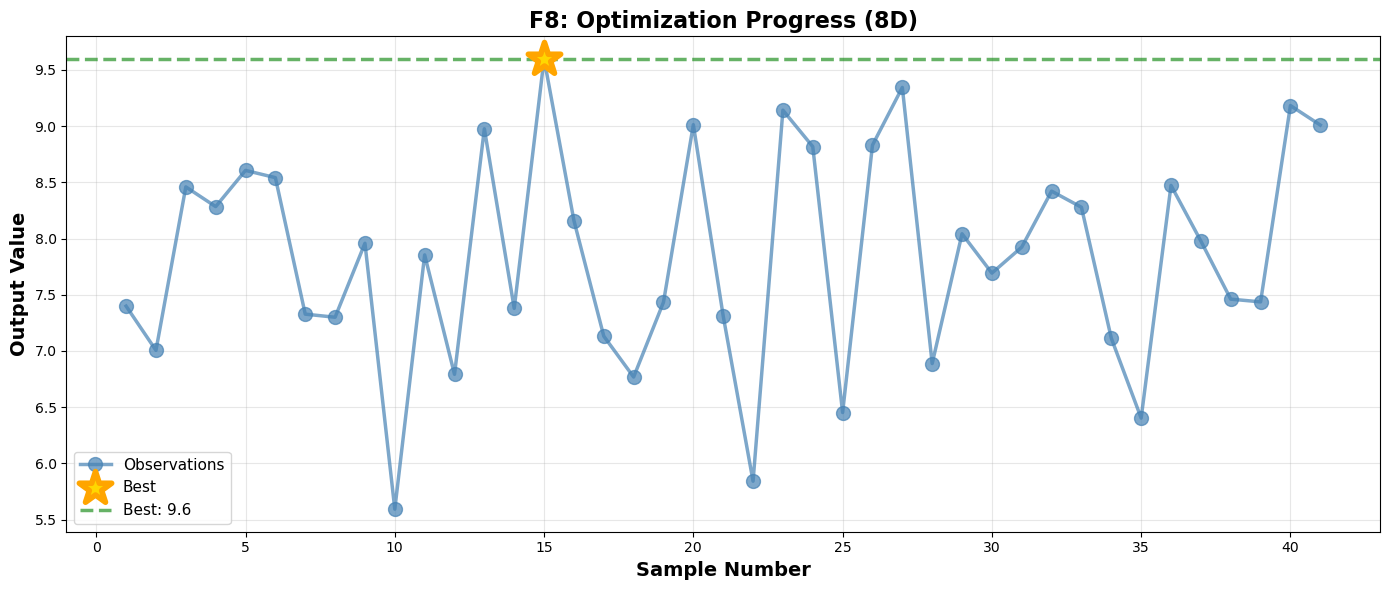

In [15]:
# Progress plot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(range(1, len(Y)+1), Y, 'o-', linewidth=2.5, markersize=10, 
        color='steelblue', alpha=0.7, label='Observations')
ax.scatter(best_idx+1, Y[best_idx], c='gold', s=600, marker='*',
           edgecolors='orange', linewidth=4, label='Best', zorder=10)
ax.axhline(y=Y[best_idx], color='green', linestyle='--', linewidth=2.5,
           alpha=0.6, label=f'Best: {Y[best_idx]:.1f}')
ax.set_xlabel('Sample Number', fontsize=14, fontweight='bold')
ax.set_ylabel('Output Value', fontsize=14, fontweight='bold')
ax.set_title('F8: Optimization Progress (8D)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 7: Final Recommendation

In [16]:
print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION FOR F8 WEEK",wk)
print("="*70)

print("\nCurrent Status:")
print(f"  Best value: {Y[best_idx]:.3f}")

print("\n⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)")
print(f"  Predicted: {mu_ei[0]:.3f} ± {sigma_ei[0]:.3f}")
print(f"  Potential improvement: {mu_ei[0] - Y[best_idx]:.3f} ({100*(mu_ei[0]/Y[best_idx]-1):.1f}%)")
print(f"  WHY: 8D is IMPOSSIBLE without BO!")

if best_local_point is not None:
    print(f"\n🥈 ALTERNATIVE: Local Refinement ({best_local_name})")
    print(f"  Predicted: {best_local_pred:.3f}")
    print(f"  Potential improvement: {best_local_pred - Y[best_idx]:.3f}")

print("\n" + "="*70)
print("8D: This is THE definition of what BO was invented for!")
print("="*70)


🎯 FINAL RECOMMENDATION FOR F8 WEEK 2

Current Status:
  Best value: 9.598

⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)
  Predicted: 10.220 ± 0.440
  Potential improvement: 0.621 (6.5%)
  WHY: 8D is IMPOSSIBLE without BO!

🥈 ALTERNATIVE: Local Refinement (X7-)
  Predicted: 9.657
  Potential improvement: 0.058

8D: This is THE definition of what BO was invented for!


## Section 8: Format Output for Submission

In [17]:
USE_EI = True  # ABSOLUTELY MANDATORY for 8D!

if USE_EI:
    x_next = x_next_ei
    method_name = "Expected Improvement (EI)"
else:
    x_next = x_next_ucb
    method_name = "Upper Confidence Bound (UCB)"

print("\n" + "="*70)
print("QUERY SUBMISSION WEEK",wk)
print("="*70)
print(f"Method: {method_name}")
print(f"Function 8 - Next point:")
for i in range(0, 8, 4):
    print(f"  X{i+1}={x_next[i]:.6f}, X{i+2}={x_next[i+1]:.6f}, X{i+3}={x_next[i+2]:.6f}, X{i+4}={x_next[i+3]:.6f}")
print("="*70)


QUERY SUBMISSION WEEK 2
Method: Expected Improvement (EI)
Function 8 - Next point:
  X1=0.000000, X2=0.179296, X3=0.000000, X4=0.071410
  X5=0.929265, X6=0.459979, X7=0.000000, X8=0.541213


In [ ]:
a/ F8 W3 with  F2 svm optimisation data SUBMISSION - ....0.043727-0.292251-0.187353-0.164402-0.798585-0.497576-0.159432-0.389606
b/ F8 W3 with svm boundry analysis  F2 data SUBMISSION . 0.118771-0.383786-0.040139-0.240734-0.768680-0.591529-0.101019-0.493876
c/ F8 w2 with F2 data My actual Submission ............- 0.000000-0.179296-0.000000-0.071410-0.929265-0.459979-0.000000-0.541213
d/ F8 W3 with svm Linier filters for GP .................0.009220-0.196741-0.109517-0.318994-0.825879-0.651530-0.168981-0.788822